In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, boxcox
from scipy import stats
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import pickle as pk

In [3]:
data = pd.read_csv("used_device_data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

In [5]:
data.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [6]:
categorical_data=pd.DataFrame(data[['device_brand', 'os','4g', '5g','rear_camera_mp','front_camera_mp','internal_memory','ram','battery','release_year','normalized_used_price','normalized_new_price']])

In [7]:
categorical_data.head()

,device_brand,os,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,release_year,normalized_used_price,normalized_new_price
0,Honor,Android,yes,no,13.0,5.0,64.0,3.0,3020.0,2020,4.307572,4.715100
1,Honor,Android,yes,yes,13.0,16.0,128.0,8.0,4300.0,2020,5.162097,5.519018
2,Honor,Android,yes,yes,13.0,8.0,128.0,8.0,4200.0,2020,5.111084,5.884631
3,Honor,Android,yes,yes,13.0,8.0,64.0,6.0,7250.0,2020,5.135387,5.630961
4,Honor,Android,yes,no,13.0,8.0,64.0,3.0,5000.0,2020,4.389995,4.947837


### Finding the percentage of missing data
Here we inspect the data and clean it. Firstly, we inspect and see how much data is present, before we can decide how to clean it

In [8]:
# Finding percentage of missing values in the data
# Since the number of data that is not found is a small proportion of the total data, removing them will not significantly
# affect the accuracy of the model.
missingValues = data.isnull().sum()

rearCameraMissing = data['rear_camera_mp'].isnull().sum()
frontCameraMissing = data['front_camera_mp'].isnull().sum()
internalMemMissing = data['internal_memory'].isnull().sum()
ramMissing = data['ram'].isnull().sum()
battMissing = data['battery'].isnull().sum()
weightMissing = data['weight'].isnull().sum()

rearCamMissPercent = (rearCameraMissing/len(data['rear_camera_mp']))*100
frontCamMissPercent = (frontCameraMissing/len(data['front_camera_mp']))*100
internalMemMissPercent = (internalMemMissing/len(data['internal_memory']))*100
ramMissPercent = (ramMissing/len(data['ram']))*100
battMissPercent = (battMissing/len(data['battery']))*100
weightMissPercent = (weightMissing/len(data['weight']))*100

print("Percentage of rear camera missing: ", rearCamMissPercent, "%")
print("Percentage of front camera missing: ", frontCamMissPercent, "%")
print("Percentage of internal memory missing: ", internalMemMissPercent, "%")
print("Percentage of ram missing: ", ramMissPercent, "%")
print("Percentage of battery missing: ", battMissPercent, "%")
print("Percentage of weight missing: ", weightMissPercent, "%")

Percentage of rear camera missing:  5.182397220613781 %
Percentage of front camera missing:  0.05790387955993051 %
Percentage of internal memory missing:  0.11580775911986102 %
Percentage of ram missing:  0.11580775911986102 %
Percentage of battery missing:  0.17371163867979156 %
Percentage of weight missing:  0.2026635784597568 %


### Values Distribution
We observe the histogram to determine if there are many outliers and whether the values are normally distributed.

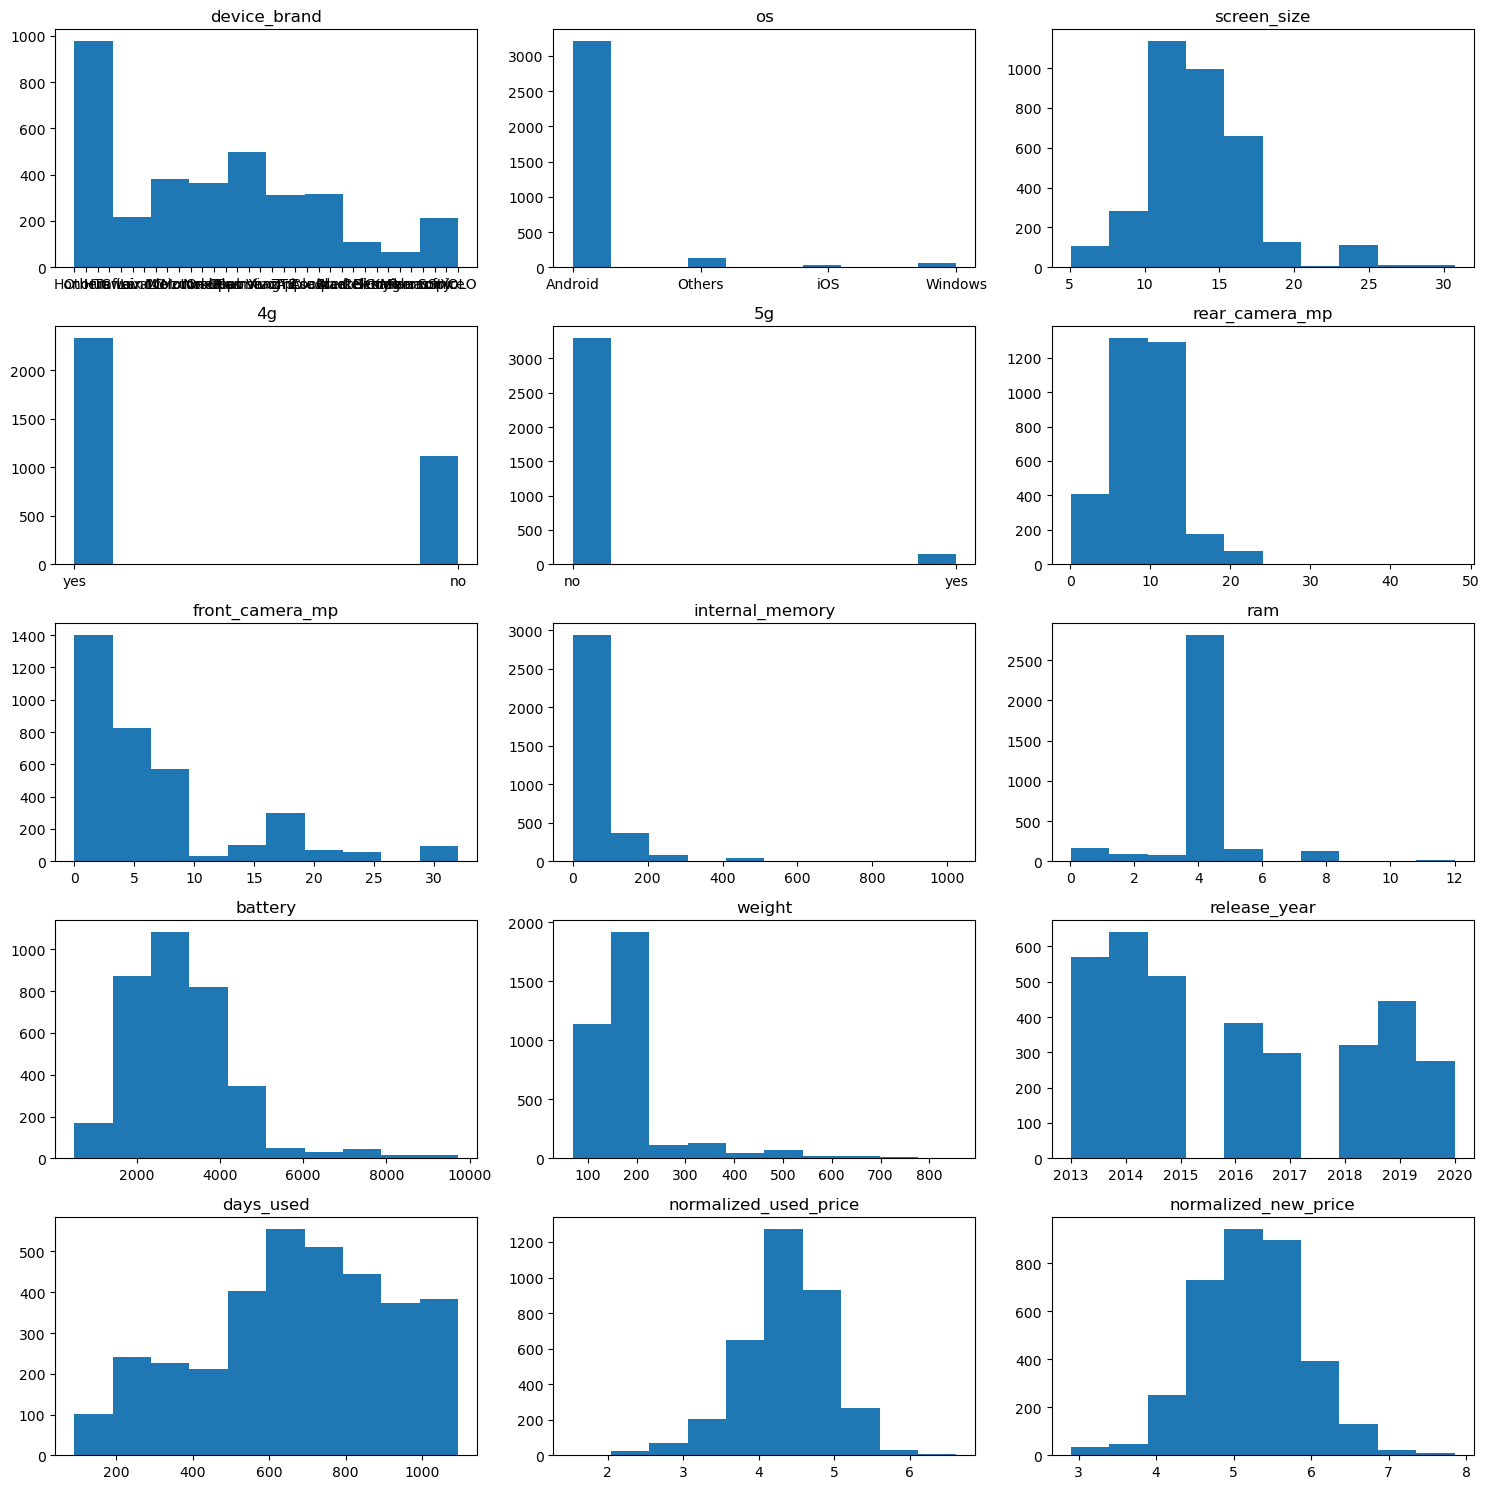

In [9]:
fig,axs= plt.subplots(5,3,figsize=(15, 15))
# Flatten the 2D array of subplots to make them easier to access
axs = axs.ravel()
for i, feature in enumerate(data.columns):
    # Plot a histogram of the feature in the current subplot
    axs[i].hist(data[feature])
    axs[i].set_title(feature)


# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()


### What to do with missing data
First we need to look at the skew of the data. If the data is not normal and is skewed, replacing the NULL values with mean or median will result in a high chance that is not accurate.Looking at the histograms, we can identify that the data is not normal, hence, we cannot use mean or median as it would not provide an accurate representation of the data.  As the number of outliers were relatively small and the fact that it would not be accurate if we used mean or median, we chose to drop the data.Therefore, we choose to drop the NULL data.

<AxesSubplot:>

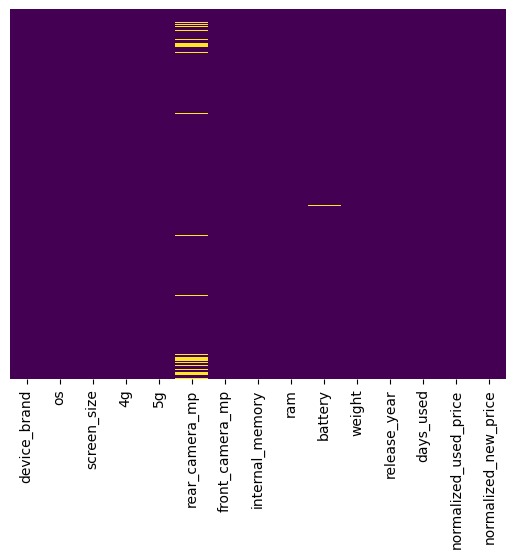

In [10]:
# Visualizing the dataset with missing data
sb.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

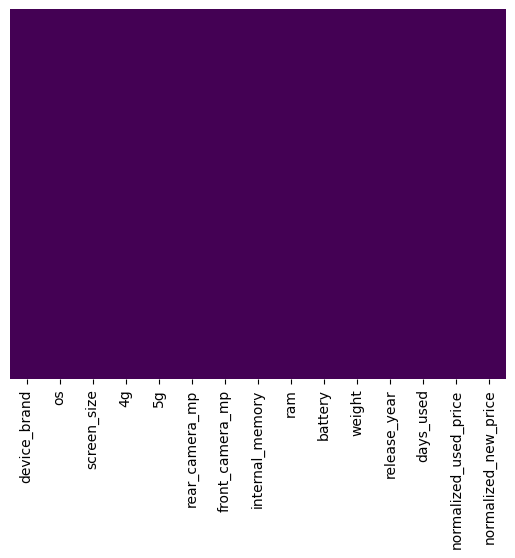

In [11]:
# Visualizing the dataset after removing the missing data
data = data.dropna()
sb.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Checking for duplicate data
To make sure there isnt contamination of the training data with the test data or vice versa. 

In [12]:
# Checking for duplicate values
data.duplicated().sum()

0

In [13]:
data

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,Apple,iOS,15.27,yes,no,8.0,7.0,64.0,4.0,3110.0,194.0,2019,208,5.100902,6.287933
3450,Asus,Android,15.24,yes,no,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


# Performing EDA on the data

# Univariate data analysis

In [14]:
# Classifying non-objects as numerical data and objects as categorical data
num_features=[feature for feature in data.columns if data[feature].dtype != 'O']
num_features

['screen_size',
 'rear_camera_mp',
 'front_camera_mp',
 'internal_memory',
 'ram',
 'battery',
 'weight',
 'release_year',
 'days_used',
 'normalized_used_price',
 'normalized_new_price']

In [15]:
cat_features=[feature for feature in data.columns if data[feature].dtype == 'O']
cat_features

['device_brand', 'os', '4g', '5g']

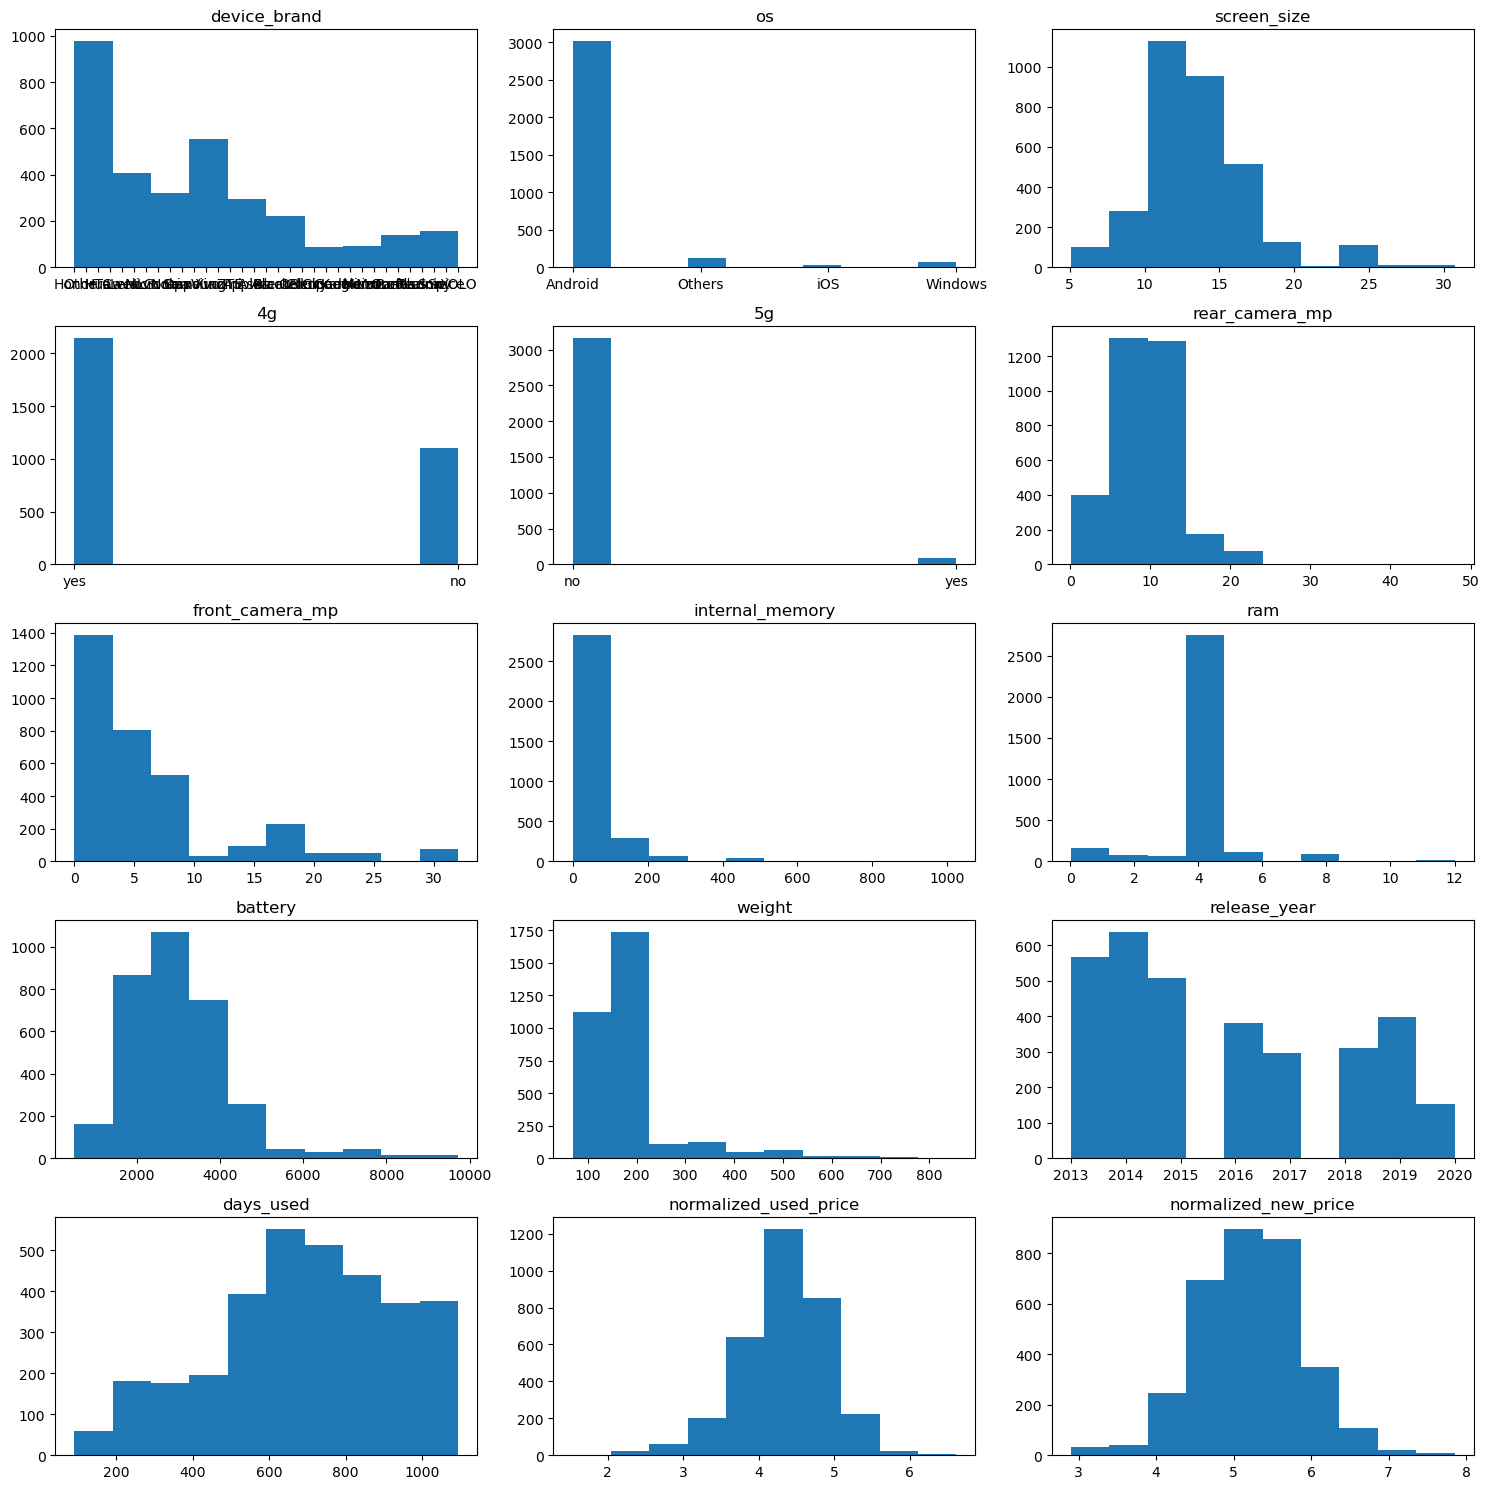

In [16]:
fig,axs= plt.subplots(5,3,figsize=(15, 15))
# Flatten the 2D array of subplots to make them easier to access
axs = axs.ravel()
for i, feature in enumerate(data.columns):
    # Plot a histogram of the feature in the current subplot
    axs[i].hist(data[feature])
    axs[i].set_title(feature)


# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()


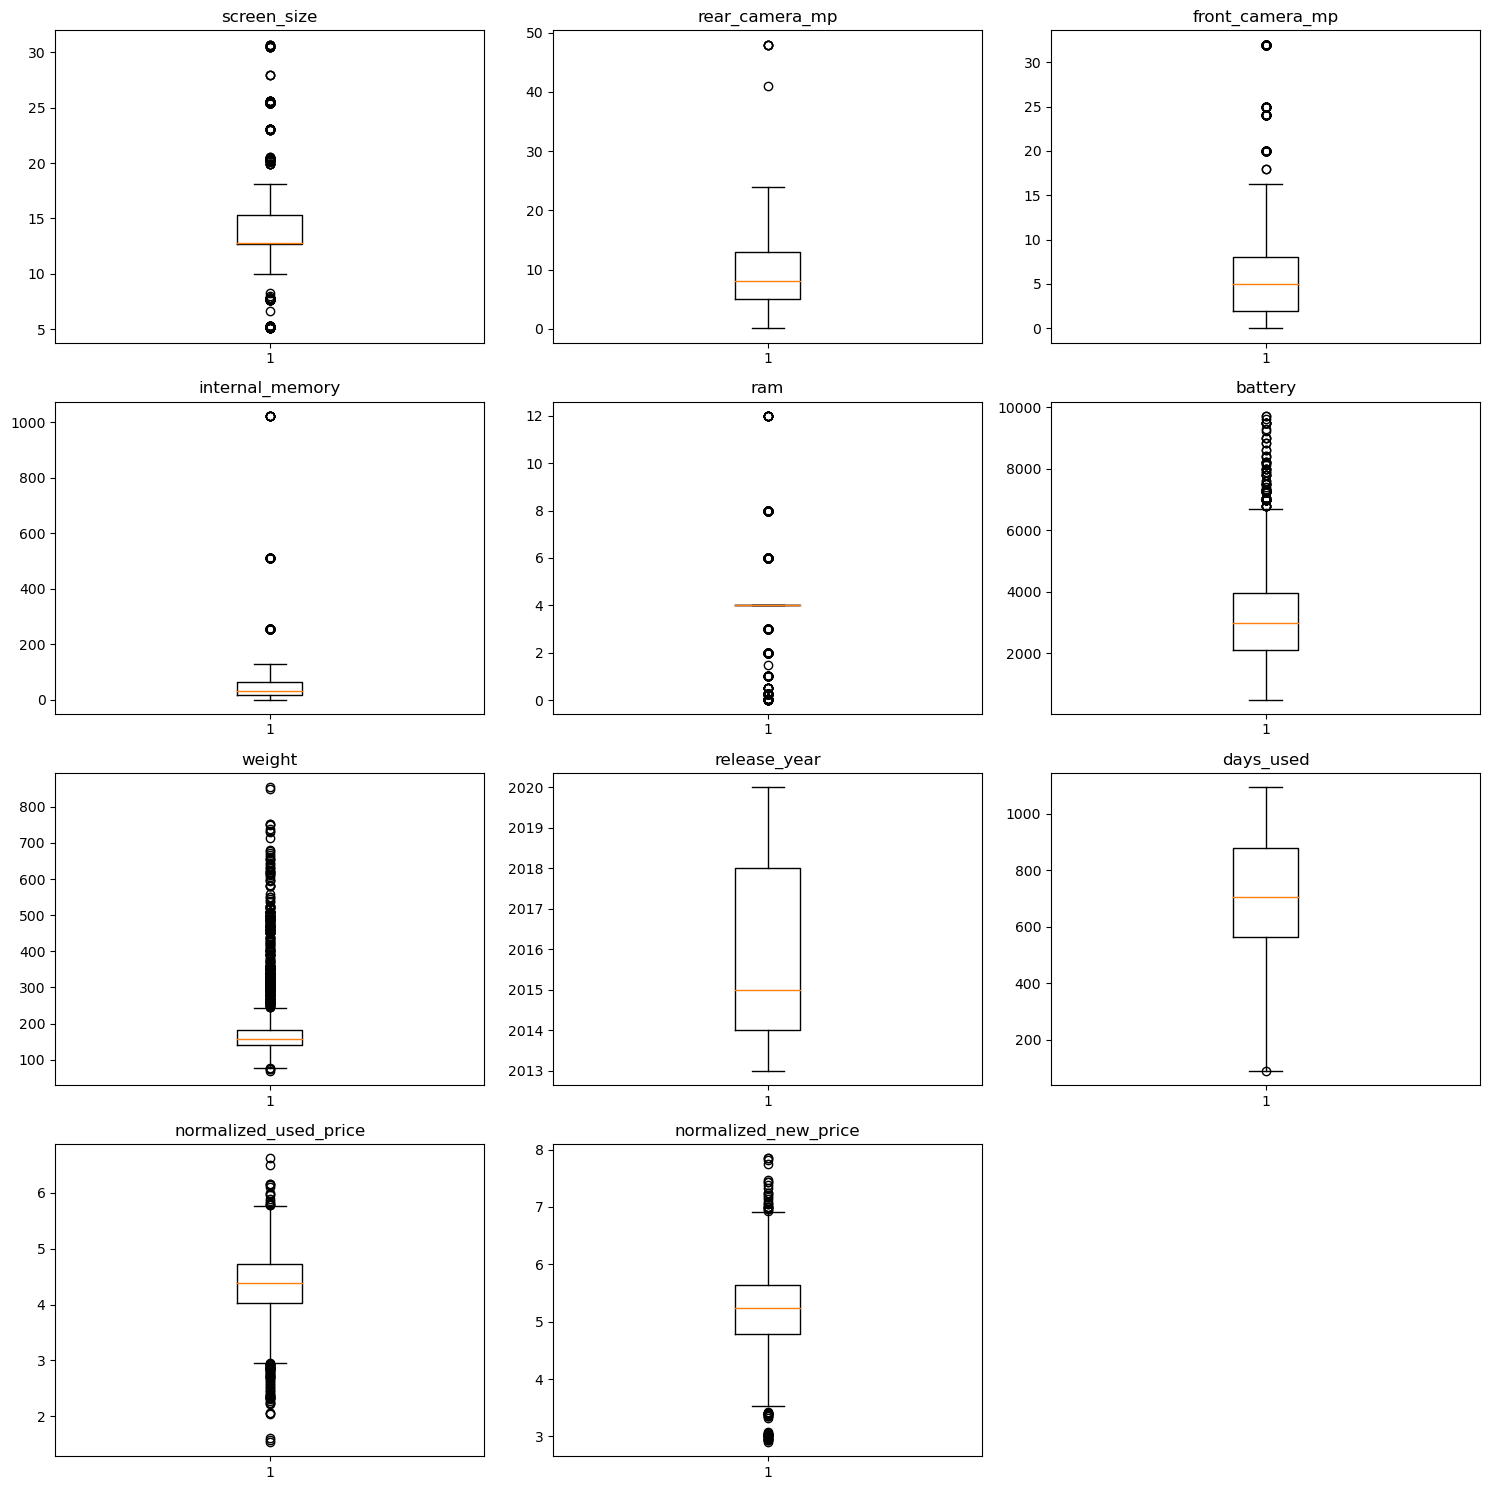

In [17]:
fig,axs= plt.subplots(4,3,figsize=(15, 15))
# Flatten the 2D array of subplots to make them easier to access
axs = axs.ravel()
for i, feature in enumerate(num_features):
    
    axs[i].boxplot(data[feature])
    axs[i].set_title(feature)

# method used to remove an axis from a figure; here removing last grid--> 12th grid since we only have 11 numerical features
fig.delaxes(axs[-1])
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

## From here we can see that a majority of the data points for RAM are clustered together at 4GB of RAM. Should RAM be removed?

### The following 2 cells can be removed if they are not important:

In [18]:
from scipy import stats
import numpy as np

# features = ['screen_size',
#  'rear_camera_mp',
#  'front_camera_mp',
#  'internal_memory',
#  'ram',
#  'battery',
#  'weight',
#  'normalized_used_price',
#  'normalized_new_price']

targetData = data[num_features]
Q1 = targetData.quantile(0.25)
Q3 = targetData.quantile(0.75)

# Rule to identify outliers
rule = ((targetData < (Q1 - 1.5 * (Q3 - Q1))) | (targetData > (Q3 + 1.5 * (Q3 - Q1))))

# Count the number of outliers
rule.sum()

# Find the rows where ANY column is True
outliers = rule.any(axis = 1)   # axis 0 is row, 1 is column

# Which row indices correspond to outliers in the dataframe?
outlierindices = outliers.index[outliers == True]

print(outliers.value_counts())

targetData.drop(axis = 0,               # 0 drops row 1 drops column
                index = outlierindices, # this takes a list as input
                inplace = True)         # not overwritten by default 

# Check the clean data
targetData





False    2206
True     1047
dtype: int64


,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
5,16.23,13.0,8.0,64.0,4.0,4000.0,176.0,2020,223,4.413889,5.060694
7,15.77,13.0,8.0,64.0,4.0,3400.0,164.0,2020,219,4.729421,5.188726
11,15.32,13.0,8.0,64.0,4.0,5000.0,185.0,2020,344,4.657383,4.770176
13,15.32,13.0,16.0,64.0,4.0,4000.0,171.5,2019,336,4.617593,5.398751
15,16.23,13.0,8.0,64.0,4.0,4000.0,176.0,2019,248,4.411221,4.866226
...,...,...,...,...,...,...,...,...,...,...,...
3427,15.32,8.0,13.0,64.0,4.0,4050.0,218.0,2020,249,4.989412,6.050087
3434,15.34,12.0,16.0,64.0,4.0,6000.0,188.0,2019,455,4.781641,5.109937
3445,15.37,8.0,7.0,64.0,4.0,3969.0,226.0,2019,298,5.340466,6.734175
3446,12.90,8.0,7.0,64.0,4.0,3046.0,188.0,2019,351,5.440164,6.713746


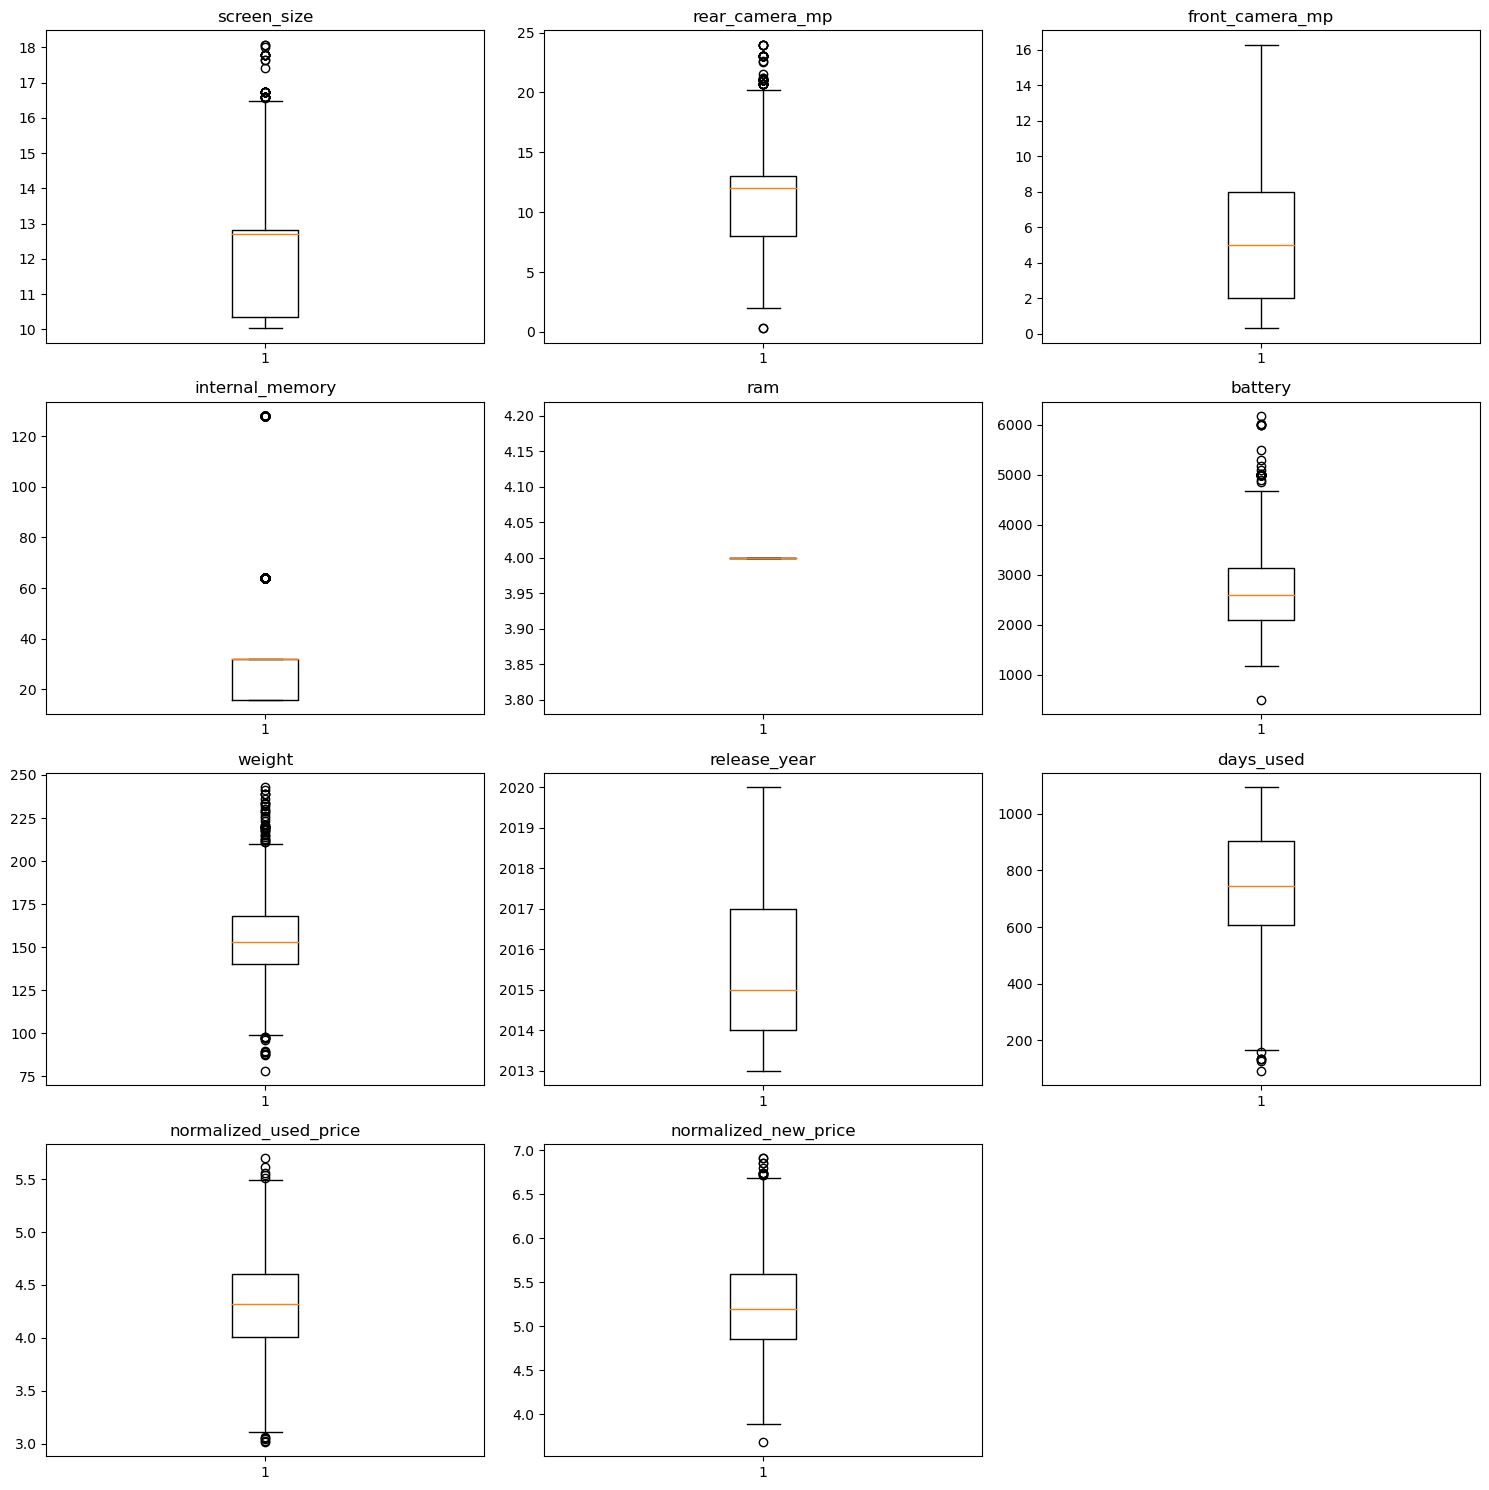

In [19]:
fig,axs= plt.subplots(4,3,figsize=(15, 15))
# Flatten the 2D array of subplots to make them easier to access
axs = axs.ravel()
for i, feature in enumerate(num_features):
    
    axs[i].boxplot(targetData[feature])
    axs[i].set_title(feature)

# method used to remove an axis from a figure; here removing last grid--> 12th grid since we only have 11 numerical features
fig.delaxes(axs[-1])
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

# Bi-variate data analysis

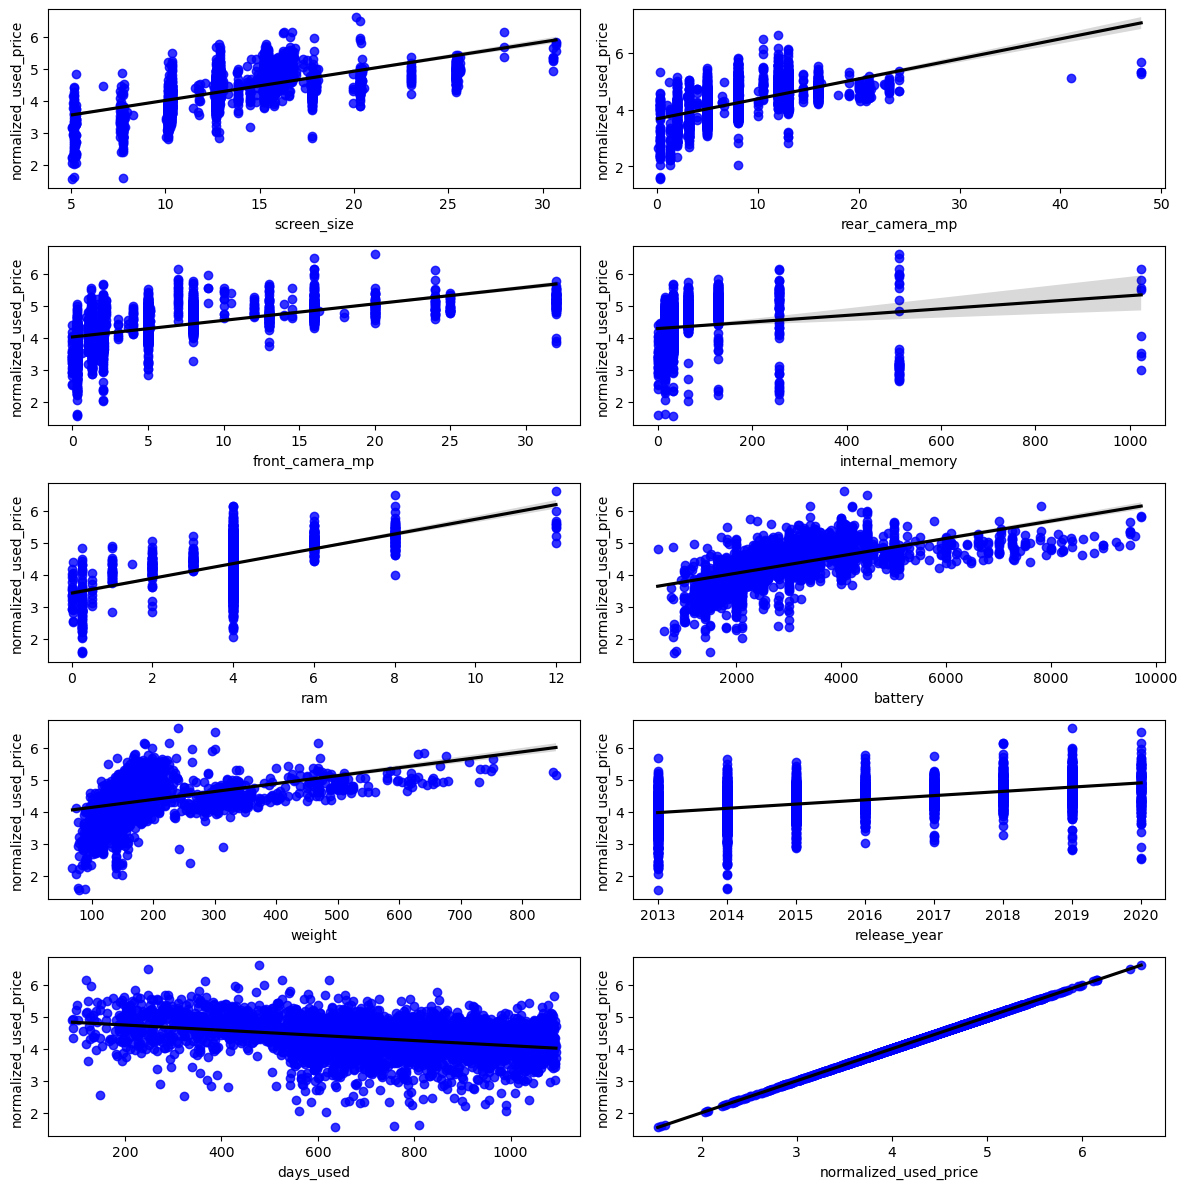

In [20]:
fig,axs= plt.subplots(5,2,figsize=(12,12))
axs=axs.ravel()
for i,ax in enumerate(axs):

    sb.regplot(x=num_features[i],y='normalized_used_price',data=data,ax=ax,color='black',scatter_kws={"color":"blue"})

plt.tight_layout()
plt.show()

## Upon further analysis in our bivariate data analysis, we discovered that there was indeed a relationship between the RAM and price of used devices. Thus, we decided to keep the variable. 

## A possible explanation for this would be manufacturing considerations such as cost, knowledge from market research among many other factors. We also decided to keep this data, as it was representative of the data.

## The linear relationships from this bivariate data analysis reassured us that the variables are related to the dependent variable, used price, which we are planning to predict. This will allow us to proceed with our regression analysis later.

<AxesSubplot:xlabel='4g', ylabel='normalized_used_price'>

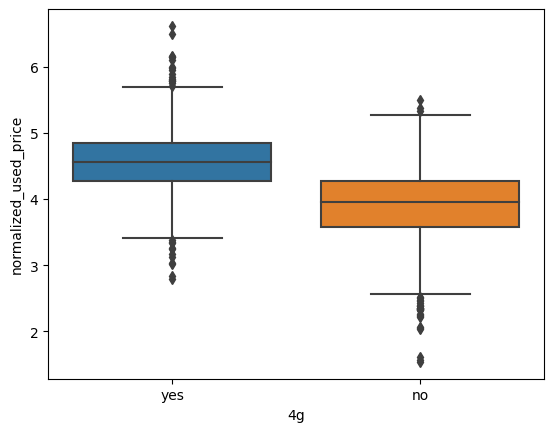

In [21]:
# Plotting the categorical data against normalised used price
sb.boxplot(data=data, x='4g', y=data['normalized_used_price'])

<AxesSubplot:xlabel='5g', ylabel='normalized_used_price'>

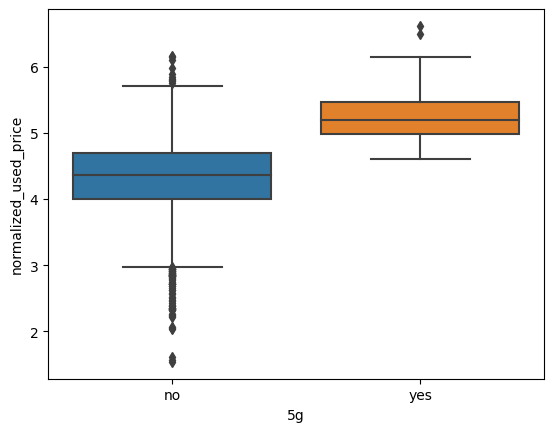

In [22]:
sb.boxplot(data=data, x='5g', y=data['normalized_used_price'])

### As seen above there is a clear difference between the boxplots of the 5g vs no 5g or 4g vs no 4g. This implies that 4g and 5g data can be used as predictors for predicting the trend of used phone price.

## Plotting Pairplot to investigate non-linear relationships, as well as possible clustering of data


In [21]:
 pairplotData = data.drop(columns=['4g', '5g'])
# sb.pairplot(data=pairplotData, hue='device_brand')

In [22]:
# pairplotData = data.drop(columns=['4g', '5g'])
# sb.pairplot(data=pairplotData, kind='kde')

### As seen in the hue of the pairplots, the screen size could be used as a predictor in predicting the normalized used price, since the data seems to be segregated into clusters of similar screen size and similar normalized used price. Perhaps we can use it to determine if the phones are "expensive". Though that requires some more definitions

### Weight and battery can be studied together with screen size to give a prediction on the price range of the used phones

### Days used and rear camera mp can also be used together to determine the price range of the used phones. The same can be observed with front camera mp as well

### Release year and days used can also be used together as well

In [23]:
# sb.pairplot(data=pairplotData, hue='screen_size')

In [24]:
# sb.pairplot(data=pairplotData, hue='os')

In [25]:
# sb.pairplot(data=pairplotData, hue='4g')

In [26]:
# sb.pairplot(data=pairplotData, hue='5g')

In [27]:
#sb.pairplot(data=pairplotData, hue='rear_camera_mp')

In [28]:
# sb.pairplot(data=pairplotData, hue='front_camera_mp')

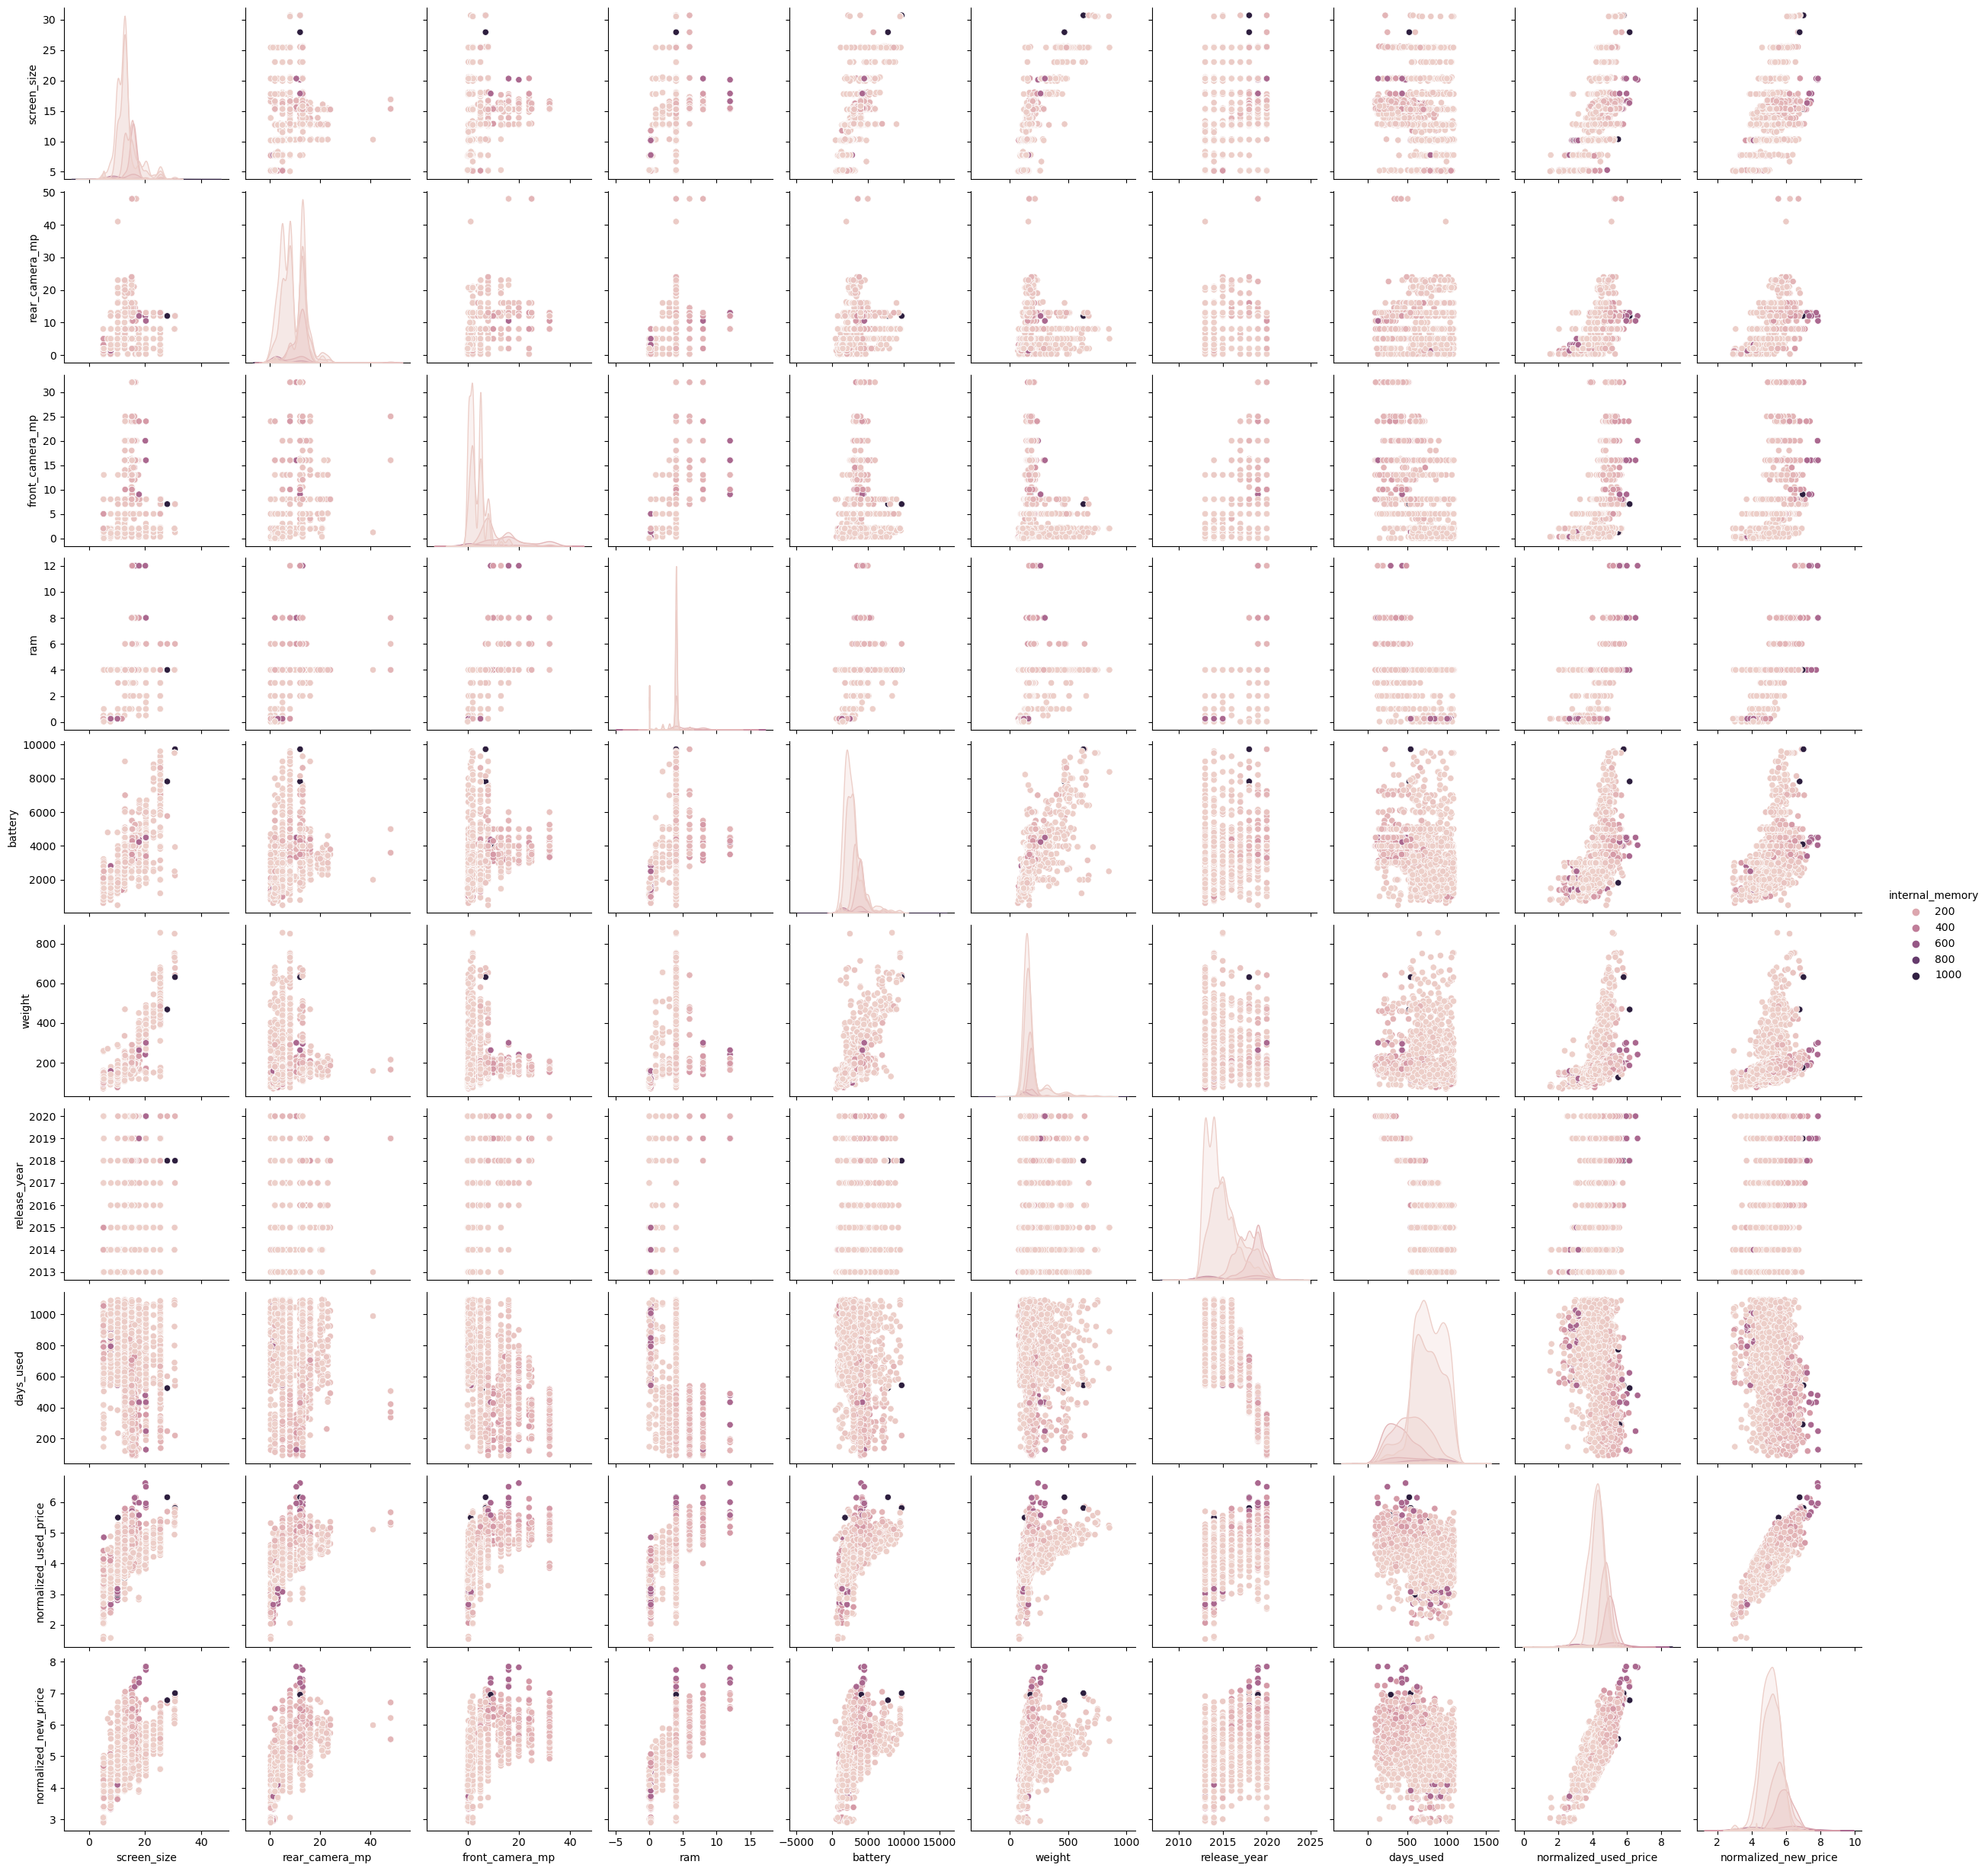

In [29]:
 sb.pairplot(data=pairplotData, hue='internal_memory')

In [30]:
# sb.pairplot(data=pairplotData, hue='ram')

In [31]:
# sb.pairplot(data=pairplotData, hue='battery')

In [32]:
# sb.pairplot(data=pairplotData, hue='weight')

In [33]:
# sb.pairplot(data=pairplotData, hue='release_year')

In [34]:
# sb.pairplot(data=pairplotData, hue='days_used')

In [35]:
# sb.heatmap(categorical_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
#            annot = True, fmt = ".2f", annot_kws = {"size": 15}, cmap = "RdBu")

# Model training and evaluation

## Implementing Principle Component Analysis and Mutual Information Regression


In [36]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer/float dtypes (double-check this before using MI!)
X.dtypes 

device_brand              int64
os                        int64
screen_size             float64
4g                        int64
5g                        int64
rear_camera_mp          float64
front_camera_mp         float64
internal_memory         float64
ram                     float64
battery                 float64
weight                  float64
release_year              int64
days_used                 int64
normalized_new_price    float64
dtype: object

In [37]:
from sklearn.feature_selection import mutual_info_regression


mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores  # show a few features with their MI scores

normalized_new_price    0.599265
screen_size             0.483542
battery                 0.417265
front_camera_mp         0.385349
rear_camera_mp          0.374098
internal_memory         0.333887
weight                  0.315748
release_year            0.186903
4g                      0.179699
ram                     0.172438
device_brand            0.133819
os                      0.066119
days_used               0.064142
5g                      0.045085
Name: MI Scores, dtype: float64

### To determine which are the most important variables are, we need to first identify which selection model we should use. When selecting the model, we need to look at the type of data, number of features, complexity of relationships. Looking at the pairplots, we identify that the relationship is non-linear. Since the relationship between the features and the target variable (normalized_used_price) is non-linear and complex, we will use Mutual Information Regression (MIR) to find the rank the variables. We then use kbest to take the top 5 variables from the results of the MIR. Here, we have identified our top 5 variables.

### Since our dataset consisted of many variables, it had a high dimensionality, which would lead to overfitting, increased computational complexity, and feature redundancy. To address this, we used PCA (Principal Component Analysis), which reduces the number of features while preserving the important information. Here, we use PCA reduce the dimensionality of the dataset, improving the accuracy and efficiency of the model.

In [38]:
from sklearn.decomposition import PCA


def PCAx(X):

    # Create a PCA model with the desired number of components
    pca = PCA()

    # Fit the PCA model to the data
    pca.fit(X)

    # Transform the data into the new feature space
    X_pca = pca.transform(X)
    return X_pca

In [39]:
#from sklearn.decomposition import PCA


#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X)
#loadings = pd.DataFrame(pca.components_, index=['PC1', 'PC2'])

#important_vars_pc1 = loadings.loc['PC1'].abs().sort_values(ascending=False)[:6]
#important_vars_pc2 = loadings.loc['PC2'].abs().sort_values(ascending=False)[:6]


#print('Most important variables for PC1:')
#print(important_vars_pc1)

#print('\nMost important variables for PC2:')
#print(important_vars_pc2)




# Selecting the K best features that describe the normalized used price

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

# Scaling and normalizing data

## Standard Scaler is used when the data is normal, whereas Min Max Scaler is used when we know the minimum and maximum value of the variables from domain knowledge. Looking at the histograms, we find that not all variables follow a normal distribution. Thus, a Min Max Scaler was used.


## Furthermore, the minimum and maximum values of a variable in the used devices are known, as they are recorded within the dataset, as well as in research literature or product information pages. Thus a Min Max Scaler was used.

In [41]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return X

In [42]:
scores=[]

# Using top 5 features to do decisionTreeRegression

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 7 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)

X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

decision_model= DecisionTreeRegressor(random_state=1)
decision_model.fit(X_train, y_train)
preds= decision_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Decision Tree Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

Decision Tree Regression with top 5 features
R2:  0.7042
MSE:  0.0953


# Using all features to perform decisionTreeRegression

In [44]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)


X= scale(X)
X= PCAx(X)

X_train,X_val,y_train,y_val= dataset(X,y)

decision_model1= DecisionTreeRegressor(random_state=1)
decision_model1.fit(X_train, y_train)
preds= decision_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Decision Tree Regreesion with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

Decision Tree Regreesion with all features
R2:  0.5966
MSE:  0.13


# Top 7 features using Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 7 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

random_model= RandomForestRegressor(random_state=1)
random_model.fit(X_train, y_train)
preds= random_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Random Forest Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

Random Forest Regression with top 5 features
R2:  0.8276
MSE:  0.0556


# All features using Random Forest Regressor

In [46]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)


X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

random_model1= RandomForestRegressor(random_state=1)
random_model1.fit(X_train, y_train)
preds= random_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Random Forest Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


Random Forest Regression with all features
R2:  0.7955
MSE:  0.0659


In [47]:
data

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,Apple,iOS,15.27,yes,no,8.0,7.0,64.0,4.0,3110.0,194.0,2019,208,5.100902,6.287933
3450,Asus,Android,15.24,yes,no,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


In [48]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price
X=pd.get_dummies(X)
colNames = X.columns
X

,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_new_price,...,device_brand_Xiaomi,device_brand_ZTE,os_Android,os_Others,os_Windows,os_iOS,4g_no,4g_yes,5g_no,5g_yes
0,14.50,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.715100,...,0,0,1,0,0,0,0,1,1,0
1,17.30,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.519018,...,0,0,1,0,0,0,0,1,0,1
2,16.69,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.884631,...,0,0,1,0,0,0,0,1,0,1
3,25.50,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.630961,...,0,0,1,0,0,0,0,1,0,1
4,15.32,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.947837,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,15.27,8.0,7.0,64.0,4.0,3110.0,194.0,2019,208,6.287933,...,0,0,0,0,0,1,0,1,1,0
3450,15.24,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,6.251538,...,0,0,1,0,0,0,0,1,1,0
3451,15.80,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.528829,...,0,0,1,0,0,0,0,1,1,0
3452,15.80,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.624188,...,0,0,1,0,0,0,0,1,1,0


# Using recursive feature elimination on the data

In [49]:
from sklearn.feature_selection import RFECV

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

# Define the estimator for RFE
random_model2 = RandomForestRegressor(random_state=1)

# Define the RFE object with 5-fold cross-validation
rfe = RFECV(estimator=random_model2, cv=5)


# Fit the RFE object to the training data
rfe.fit(X_train, y_train)

# Print the selected features
print("Selected features: ", np.array(colNames)[rfe.support_])

# Transform the training and validation data using the selected features
X_train_rfe = rfe.transform(X_train)
X_val_rfe = rfe.transform(X_val)

# Fit a new random forest model using the selected features
random_model_rfe = RandomForestRegressor(random_state=1)
random_model_rfe.fit(X_train_rfe, y_train)
preds_rfe = random_model_rfe.predict(X_val_rfe)

# Calculate R2 and MSE for the new model
r2_rfe = r2_score(y_val, preds_rfe)
MSE_rfe = mean_squared_error(y_val, preds_rfe)

# Print the results
a_rfe = "Random Forest Regression with selected features (RFE)"
print(a_rfe)
print("R2: ", round(r2_rfe, 4))
print("MSE: ", round(MSE_rfe, 4))

scores.append((a_rfe, round(r2_rfe, 4), round(MSE_rfe, 4)))

Selected features:  ['screen_size' 'rear_camera_mp' 'front_camera_mp' 'internal_memory' 'ram'
 'battery' 'weight' 'release_year' 'days_used' 'normalized_new_price'
 'device_brand_Alcatel' 'device_brand_Others' 'device_brand_Samsung'
 'os_Android' '4g_no']
Random Forest Regression with selected features (RFE)
R2:  0.8234
MSE:  0.0569


# Top 7 features using Linear Regression

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 7 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

linear_model= LinearRegression()
linear_model.fit(X_train, y_train)
preds= linear_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Linear Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


Linear Regression with top 5 features
R2:  0.8222
MSE:  0.0573


# All features using Linear Regression

In [51]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

linear_model1= LinearRegression()
linear_model1.fit(X_train, y_train)
preds= linear_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Linear Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


Linear Regression with all features
R2:  0.8274
MSE:  0.0557


# Performing Ridge Regression using top 7 features

In [52]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 7 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

ridge_model= Ridge(random_state=1)
ridge_model.fit(X_train, y_train)
preds= ridge_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Ridge Regression with top 7 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


Ridge Regression with top 7 features
R2:  0.8227
MSE:  0.0572


# Performing Ridge Regression using all variables

In [53]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)


X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

ridge_model1= Ridge(random_state=1)
ridge_model1.fit(X_train, y_train)
preds= ridge_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Ridge Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


Ridge Regression with all features
R2:  0.8282
MSE:  0.0554


# Performing Lasso Regression using top 7 variables

In [54]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 5 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

lasso_model= Lasso(random_state=1)
lasso_model.fit(X_train, y_train)
preds= lasso_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Lasso Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


Lasso Regression with top 5 features
R2:  -0.02
MSE:  0.3288


# Performing Lasso Regression using all variables

In [55]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

lasso_model1= Lasso(random_state=1)
lasso_model1.fit(X_train, y_train)
preds= lasso_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Lasso Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


Lasso Regression with all features
R2:  -0.02
MSE:  0.3288


# Performing Support Vector Regression using top 7 features

In [56]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 5 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

svm_model= SVR(kernel='linear')
svm_model.fit(X_train, y_train)
preds= svm_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "SVM Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


SVM Regression with top 5 features
R2:  0.8197
MSE:  0.0581


# Performing Support Vector Regression using all variables

In [57]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)


X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

svm_model1= SVR(kernel='linear')
svm_model1.fit(X_train, y_train)
preds= svm_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "SVM Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


SVM Regression with all features
R2:  0.8273
MSE:  0.0557


In [58]:
columns=['models','R2','MSE']
score= pd.DataFrame(scores, columns=columns)
score

,models,R2,MSE
0,Decision Tree Regression with top 5 features,0.7042,0.0953
1,Decision Tree Regreesion with all features,0.5966,0.1300
2,Random Forest Regression with top 5 features,0.8276,0.0556
3,Random Forest Regression with all features,0.7955,0.0659
4,Random Forest Regression with selected feature...,0.8234,0.0569
5,Linear Regression with top 5 features,0.8222,0.0573
6,Linear Regression with all features,0.8274,0.0557
7,Ridge Regression with top 7 features,0.8227,0.0572
8,Ridge Regression with all features,0.8282,0.0554
9,Lasso Regression with top 5 features,-0.0200,0.3288
